In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, MaxPool2D
import Levenshtein

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
class configuration:
    seed = 12345
    batch_size = 32
    init_lr = 1e-3
    img_size = 100
    class_mode = "raw"
    n_CLASS = 12
    interpolation = "nearest"
    color_mode = "grayscale"
    shuffle = True
    num_data = 1000
    test_size = 0.05

Setting configurations for model and preprocessing

In [4]:
train_dir = "../input/bms-molecular-translation/train"
arranged_data_path = "../input/bms-molecular-translation/arranged_bms_train_labels.csv"

In [5]:
arranged_data = pd.read_csv(arranged_data_path)

In [6]:
# seed
tf.random.set_seed(configuration.seed)
np.random.seed(configuration.seed)
random.seed(configuration.seed)
os.environ["PYTHONHASHSEED"] = str(configuration.seed)

In [7]:
# I was truncate data to 1000000 due to the calculation time, but more data would be increase your accuracy
list_of_atom = ["C", "H", "B", "Br", "Cl", "F", "I", "N", "O", "P", "S", "Si"]
data = arranged_data[["image_path", *list_of_atom]].copy()
data = data.sample(n=configuration.num_data, random_state=configuration.seed)
data_1 = arranged_data[["image_path", *list_of_atom]].copy()
data_1 = data_1.sample(n=2000, random_state=configuration.seed)

In [8]:
print(data.shape)
print(data.head(2))
print(data_1.shape)
print(data_1.head(2))

(1000, 13)
                                               image_path   C   H  B  Br  Cl  \
902574  ../input/bms-molecular-translation/train/5/f/3...  32  61  0   0   0   
74658   ../input/bms-molecular-translation/train/0/7/d...  15  11  0   0   0   

        F  I  N  O  P  S  Si  
902574  0  1  0  4  0  0   2  
74658   4  0  1  2  0  0   0  
(2000, 13)
                                               image_path   C   H  B  Br  Cl  \
902574  ../input/bms-molecular-translation/train/5/f/3...  32  61  0   0   0   
74658   ../input/bms-molecular-translation/train/0/7/d...  15  11  0   0   0   

        F  I  N  O  P  S  Si  
902574  0  1  0  4  0  0   2  
74658   4  0  1  2  0  0   0  


Creating two dataframes, one with 1000 sample points, other with 2000 sample points, for hyperparameter tuning and evaluating model performance on the basis of training dataset size.

In [9]:
def transform_function(image):
    return image / 255.

In [10]:
training_data = ImageDataGenerator(preprocessing_function = transform_function)
validation_data = ImageDataGenerator(preprocessing_function = transform_function)

In [11]:
def generate_image_dataset(d):
    dataset = training_data.flow_from_dataframe(d, 
                                                directory = None,
                                                seed = configuration.seed,
                                                x_col = "image_path",
                                                y_col = list_of_atom,
                                                target_size = (configuration.img_size, configuration.img_size),
                                                class_mode = configuration.class_mode,
                                                interpolation = configuration.interpolation,
                                                shuffle = configuration.shuffle,
                                                color_mode = configuration.color_mode,
                                                batch_size = configuration.batch_size)
    return dataset

Method to generate Image data for augmentation of image data in realtime. ImageDataGenerator is a package that helps transform and preprocess training images. Here we transform the image by resizing it and bringing it to the same color gradient.

In [12]:
train, validation = train_test_split(data, test_size=configuration.test_size, random_state=configuration.seed)
train_1, validation_1 = train_test_split(data_1, test_size=configuration.test_size, random_state=configuration.seed)

Splitting data for training and validation

In [13]:
print(train.shape)
print(validation.shape)
print(train_1.shape)
print(validation_1.shape)

(950, 13)
(50, 13)
(1900, 13)
(100, 13)


In [14]:
train_set = generate_image_dataset(train)
valid_set = generate_image_dataset(validation)
train_set_1 = generate_image_dataset(train_1)
valid_set_1 = generate_image_dataset(validation_1)

Found 950 validated image filenames.
Found 50 validated image filenames.
Found 1900 validated image filenames.
Found 100 validated image filenames.


From the 1000 dataset we have 950 images in the training dataset and 50 in validation, similarly from 2000 dataset we have 1900 images in training dataset and 100 in validation

# Creating Deep Neural Network Model using Keras

In [15]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", padding="same", input_shape=(configuration.img_size, configuration.img_size, 1)))
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Conv2D(32, 3, activation="relu", padding="same"))
    model.add(Conv2D(32, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(Conv2D(16, 3, activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(configuration.n_CLASS, activation="relu"))
    return model

model = create_model()
model.summary()

2022-08-11 10:53:04.873858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        9

Here we build a 3 layered network with 16, 32, 16 nodes in each layer respectively. The activation function we have used is ReLu (Rectifies Linear Unit) as it tends to converge quickly and performs better with deeper networks.

Each layer is a Convolutional 2D which applies a convoluation to every image and brings it to a 2D from a multi-plane image. The first layers input size is the same as the input size of the training dataset's features, which in this case is the size of the image, set to 380 pixels.

When training deep neural networks, a technique called batch normalization is used to equalize the inputs to each layer for each mini-batch. After every layer we have performed batch normalization. As a result, the learning process is stabilized and the quantity of training epochs needed to train deep networks is drastically decreased.



In [16]:
step_size_train = train_set.n // train_set.batch_size
step_size_valid = valid_set.n // valid_set.batch_size

step_size_train_1 = train_set_1.n // train_set_1.batch_size
step_size_valid_1 = valid_set_1.n // valid_set_1.batch_size

In [21]:
model = create_model()
model.load_weights("bms_formula_model.h5")
checkpoint_cb = ModelCheckpoint("bms_formula_best_model.h5", save_best_only=True, monitor="val_loss", mode="min")

lr = CosineDecay(initial_learning_rate = configuration.init_lr, decay_steps = step_size_train * 5)

model.compile(optimizer = Adam(learning_rate=lr), loss="mean_squared_error", metrics=["mean_squared_error"])

history = model.fit(train_set,
                    validation_data = valid_set,
                    epochs = 5,
                    batch_size = configuration.batch_size,
                    steps_per_epoch = step_size_train,
                    validation_steps = step_size_valid,
                    callbacks=[checkpoint_cb])

model.save("bms_model.h5")

Epoch 1/5
29/29 [==============================] - 19s 625ms/step - loss: 69.2781 - mean_squared_error: 69.2781 - val_loss: 20.5803 - val_mean_squared_error: 20.5803
Epoch 2/5
29/29 [==============================] - 18s 610ms/step - loss: 65.3118 - mean_squared_error: 65.3118 - val_loss: 24.9826 - val_mean_squared_error: 24.9826
Epoch 3/5
29/29 [==============================] - 18s 623ms/step - loss: 63.3542 - mean_squared_error: 63.3542 - val_loss: 32.7343 - val_mean_squared_error: 32.7343
Epoch 4/5
29/29 [==============================] - 18s 630ms/step - loss: 61.5021 - mean_squared_error: 61.5021 - val_loss: 52.2044 - val_mean_squared_error: 52.2044
Epoch 5/5
29/29 [==============================] - 17s 599ms/step - loss: 61.3626 - mean_squared_error: 61.3626 - val_loss: 53.3727 - val_mean_squared_error: 53.3727


Reducing Loss percentage indicates that with every epoch, the model is learning better and is reducing its mean squared error. Here we have restricted our model to run minimal epochs, as we increase the epoch, performance will increase.

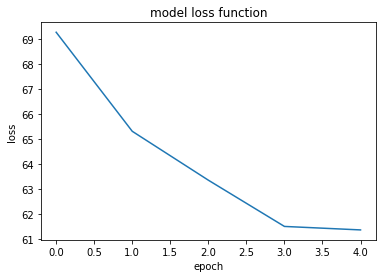

In [22]:
plot.plot(history.history['loss'])
plot.title('model loss function')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.show()

In [23]:
def array_to_iupac(a):
    f = ""
    for atom, num in zip(list_of_atom, a):
        if num > 1:
            f += "%s%s" % (atom, int(num))
        elif num == 1:
            f += atom
    return f

In [24]:
lsval = 0.

for i, (test, formula_list) in enumerate(tqdm(train_set)):
    if i >= len(train_set):
        break
    predicts = np.round(model.predict(test))
    for predict, formula in zip(predicts, formula_list):
        predict_iupac = array_to_iupac(predict)
        true_iupac = array_to_iupac(formula)
        lsval += Levenshtein.distance(predict_iupac, true_iupac) / (configuration.num_data * (1 - configuration.test_size))

print("The Levenshtein distance of train data is %s" % lsval)

  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 225ms/step
The Levenshtein distance of train data is 7.7284210526315835


Levenshtein distance is calculated as the number of characters which need to be changed in the predicted string as compared to the original string. The original string here are the chemical structure of the given molecular compound. The maximum length of the chemical structure in this dataset (found in the EDA.ipynb) is 397, the average length of the chemical structure in this dataset (found in the EDA.ipynb) is 120.03.

Our model predicts the same chemical structure with an average error of 7 characters.

In [25]:
def create_model_1():
    model_1 = Sequential()
    model_1.add(Conv2D(16, 3, activation="relu", padding="same", input_shape=(configuration.img_size, configuration.img_size, 1)))
    model_1.add(Conv2D(16, 3, activation="relu", padding="same"))
    model_1.add(BatchNormalization())
    model_1.add(MaxPool2D(pool_size=(2, 2), strides=None, padding="valid"))
    model_1.add(Conv2D(32, 3, activation="sigmoid", padding="same"))
    model_1.add(Conv2D(32, 3, activation="sigmoid", padding="same"))
    model_1.add(BatchNormalization())
    model_1.add(MaxPool2D(pool_size=(2, 2), strides=None, padding="valid"))
    model_1.add(Conv2D(64, 3, activation="sigmoid", padding="same"))
    model_1.add(Conv2D(64, 3, activation="sigmoid", padding="same"))
    model_1.add(BatchNormalization())
    model_1.add(MaxPool2D(pool_size=(2, 2), strides=None, padding="valid"))
    model_1.add(Conv2D(64, 3, activation="relu", padding="same"))
    model_1.add(Conv2D(64, 3, activation="relu", padding="same"))
    model_1.add(BatchNormalization())
    model_1.add(GlobalAveragePooling2D())
    model_1.add(Dense(configuration.n_CLASS, activation="relu"))
    return model_1

model_1 = create_model_1()
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 100, 100, 16)      160       
                                                                 
 conv2d_31 (Conv2D)          (None, 100, 100, 16)      2320      
                                                                 
 batch_normalization_15 (Bat  (None, 100, 100, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 conv2d_33 (Conv2D)          (None, 50, 50, 32)       

In [26]:
model_1 = create_model_1()
model.load_weights("bms_formula_model_1.h5")

lr = CosineDecay(initial_learning_rate = configuration.init_lr, decay_steps = step_size_train_1 * 10)

model_1.compile(optimizer = Adam(learning_rate=lr), loss="mean_squared_error", metrics=["mean_squared_error"])

checkpoint_cb = ModelCheckpoint("bms_formula_best_model_1.h5", save_best_only=True, monitor="val_loss", mode="min")

history_1 = model_1.fit(train_set_1,
                    validation_data = valid_set_1,
                    epochs = 10,
                    batch_size = configuration.batch_size,
                    steps_per_epoch = step_size_train_1,
                    validation_steps = step_size_valid_1,
                    callbacks=[checkpoint_cb])

model.save("bms_model_1.h5")

Epoch 1/10
59/59 [==============================] - 46s 752ms/step - loss: 65.2639 - mean_squared_error: 65.2639 - val_loss: 55.4069 - val_mean_squared_error: 55.4069
Epoch 2/10
59/59 [==============================] - 44s 745ms/step - loss: 54.7411 - mean_squared_error: 54.7411 - val_loss: 36.2005 - val_mean_squared_error: 36.2005
Epoch 3/10
59/59 [==============================] - 47s 789ms/step - loss: 49.1049 - mean_squared_error: 49.1049 - val_loss: 45.0813 - val_mean_squared_error: 45.0813
Epoch 4/10
59/59 [==============================] - 46s 779ms/step - loss: 44.4756 - mean_squared_error: 44.4756 - val_loss: 37.4212 - val_mean_squared_error: 37.4212
Epoch 5/10
59/59 [==============================] - 47s 791ms/step - loss: 43.1310 - mean_squared_error: 43.1310 - val_loss: 33.6601 - val_mean_squared_error: 33.6601
Epoch 6/10
59/59 [==============================] - 46s 783ms/step - loss: 40.9947 - mean_squared_error: 40.9947 - val_loss: 47.8300 - val_mean_squared_error: 47.830

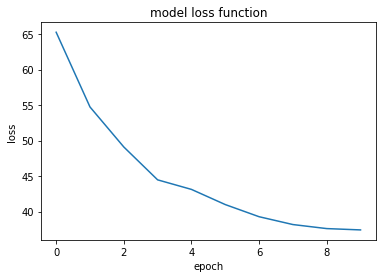

In [27]:
plot.plot(history_1.history['loss'])
plot.title('model loss function')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.show()

In [36]:
lsval_1 = 0.
for i, (test, formula_list) in enumerate(tqdm(train_set)):
    if i >= len(train_set):
        break
    predicts_1 = np.round(model_1.predict(test))
    for predict, formula in zip(predicts_1, formula_list):
        predict_iupac = array_to_iupac(predict)
        true_iupac = array_to_iupac(formula)
        lsval_1 += Levenshtein.distance(predict_iupac, true_iupac) / (configuration.num_data * (1 - configuration.test_size))

print("The Levenshtein distance of train data is %s" % lsval_1)

  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 343ms/step
The Levenshtein distance of train data is 8.956842105263165


Levenshtein distance is calculated as the number of characters which need to be changed in the predicted string as compared to the original string. The original string here are the chemical structure of the given molecular compound. The maximum length of the chemical structure in this dataset (found in the EDA.ipynb) is 397, the average length of the chemical structure in this dataset (found in the EDA.ipynb) is 120.03.

Our model predicts the same chemical structure with an average error of 8 characters.